In [14]:
import numpy as np
import pandas as pd
import pickle
import numexpr as ne
import matplotlib.pyplot as plt
from functools import partial
import re

## Load raw price data for strategy backtest

In [3]:
with open('data/stockData_1', 'rb') as p:
    df = pickle.load(p)
    p.close()

for i in range(2, 28):
    with open('data/stockData_'+str(i), 'rb') as p:
        df1 = pickle.load(p)
        df = df.concat([df, df1])
        p.close()

print(df.head())
df = df.reset_index(drop=False).set_index(['PERMNO','date'])
all_permno = np.unique([x[0] for x in df.index.values])[:1350]
all_dates = np.unique([x[1] for x in df.index.values])

            date     PRC       VOL   BIDLO   ASKHI
PERMNO                                            
63773   19960102  39.750   61400.0  39.125  39.875
63773   19960103  39.875  105000.0  39.500  40.125
63773   19960104  39.750   69500.0  39.500  40.000
63773   19960105  40.500   42800.0  39.375  40.500
63773   19960108  40.125   46300.0  40.125  40.625


## Set global hyperparameters and load predicted signals from previous optimal model

In [4]:
image_size = 16 # Compress information for every 4 days;
data_len = int(252/4)+1
retrain_freq = 5
nDays = len(all_dates)

with open('data/predictions', 'rb') as p:
    signals = pickle.load(p)
    p.close()

signals = pd.DataFrame(signals)
signals.columns = [['long', 'hold', 'short']]

## Align dates of portfolio rebalance and stock PERMNO

In [5]:
rebalance_dates = [all_dates[i] for i in range(data_len, nDays, retrain_freq)]
rebalance_dates = rebalance_dates[int(len(rebalance_dates)*2/3)+1:]
n = len(rebalance_dates)
signals['PERMNO'] = np.array([[x]*n for x in all_permno]).ravel()
signals['rebalance_dates'] = rebalance_dates*1350

## Get price of stock at each rebalance date

In [6]:
df1 = df.reset_index(level=0, drop=False).reset_index(drop=False)
iv = df1.date
prc_dict = {x: df1[ne.evaluate('iv==x')][['PRC', 'PERMNO']] for x in rebalance_dates}

In [7]:
iv = signals.rebalance_dates
signal_dict = {x: signals[ne.evaluate('iv==x')][['long', 'hold', 'short', 'PERMNO']] for x in rebalance_dates}

## Form portfolio for each rebalance date
Only incorporate stocks that we predict to go long with highest probability (top 20 stocks)

In [8]:
long_portfolio_dict, short_portfolio_dict = {}, {}
for dd in rebalance_dates:
    today_long = signal_dict[dd][signal_dict[dd][['long', 'hold', 'short']].idxmax(axis=1)==('long',)].sort_values(by=[('long',)], ascending=False)
    
    today_long_portfolio = today_long['PERMNO'][:15].values.ravel()

    long_portfolio_dict[dd] = today_long_portfolio


Get the date to open and close the selected stocks in the portfolio

In [9]:
def get_next_date(today, all_dates=rebalance_dates):
    today_idx = np.where(np.array(all_dates)==today)
    if len(today_idx)==0:
        return
    if today_idx[0][0] == len(all_dates)-1:
        return
    return all_dates[today_idx[0][0]+1]

portfolio_return = []

for date in rebalance_dates[:-1]:
    long_portfolio = long_portfolio_dict[date]
    
    open_day = prc_dict[date][prc_dict[date].PERMNO.isin(long_portfolio)]
    close_day = prc_dict[get_next_date(date)][prc_dict[get_next_date(date)].PERMNO.isin(long_portfolio)]
    
    portfolio_return.append((np.average((close_day.PRC.values-open_day.PRC.values)/open_day.PRC.values)))

portfolio_NAV = np.cumprod(np.array(portfolio_return)+1)

Get benchmark sp500 returns

In [10]:
sp500 = pd.read_csv('data/^GSPC.csv', index_col=False)[['Date', 'Adj Close']]
sp500.Date = sp500.Date.apply(partial(re.sub, '-', '')).apply(int)
sp500 = sp500[sp500.Date.isin(rebalance_dates)]
sp500_NAV = np.cumprod(1+((sp500['Adj Close'].iloc[1:].values-sp500['Adj Close'].iloc[0:-1].values)/sp500['Adj Close'].iloc[0:-1].values))


## Comparison of the returns

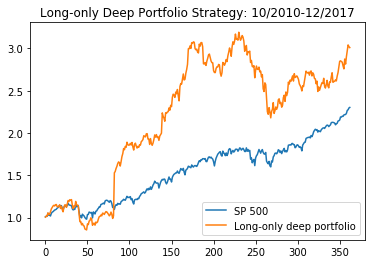

In [15]:
plt.plot(figsize=(30, 10))
plt.plot(sp500_NAV)
plt.plot(portfolio_NAV)
plt.legend(['SP 500', 'Long-only deep portfolio'])
plt.title('Long-only Deep Portfolio Strategy: 10/2010-12/2017')
plt.show()
